BERT


In [2]:
!pip install -U transformers datasets seqeval accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.9 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=85447fdcbe4c3f754b569972dee3d0f3edf3f3a7bc67d9fc566bf86f6c71ac41
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [3]:
!pip install -q transformers seqeval

import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import BertTokenizerFast, BertForTokenClassification
from seqeval.metrics import classification_report, f1_score

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [4]:
from google.colab import files

uploaded = files.upload()
conll_filename = list(uploaded.keys())[0]
print("Using file:", conll_filename)

Saving project-7-at-2025-12-17-00-39-573c05e7.conll to project-7-at-2025-12-17-00-39-573c05e7.conll
Using file: project-7-at-2025-12-17-00-39-573c05e7.conll


In [5]:
def read_conll(path):
    sentences = []
    labels = []
    cur_tokens = []
    cur_labels = []

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()

            # Sentence boundary
            if not line:
                if cur_tokens:
                    sentences.append(cur_tokens)
                    labels.append(cur_labels)
                    cur_tokens, cur_labels = [], []
                continue

            parts = line.split()
            if len(parts) < 2:
                continue

            token = parts[0]
            label = parts[-1]

            if token == "-DOCSTART-":
                continue

            cur_tokens.append(token)
            cur_labels.append(label)

    # Last sentence if no blank line at end
    if cur_tokens:
        sentences.append(cur_tokens)
        labels.append(cur_labels)

    return sentences, labels

sentences, labels = read_conll(conll_filename)
print("Number of sentences:", len(sentences))
print("Example tokens:", sentences[0][:20])
print("Example labels:", labels[0][:20])


Number of sentences: 132
Example tokens: ['Abbat', ',', 'William', '(', 'fl.', '1464-71', ')', '.', 'Abbott.', '372', '.']
Example labels: ['B-FamilyName', 'O', 'B-FirstName', 'O', 'B-FlourishedDate', 'I-FlourishedDate', 'O', 'O', 'B-SocialStatus', 'B-PlotNumber', 'O']


In [6]:
#Get all unique labels
unique_labels = sorted({lab for sent in labels for lab in sent})
label2id = {lab: i for i, lab in enumerate(unique_labels)}
id2label = {i: lab for lab, i in label2id.items()}

print("Labels:", unique_labels)
print("Number of labels:", len(unique_labels))

model_name = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
MAX_LEN = 128



Labels: ['B-Date', 'B-FamilyName', 'B-FamilyRelation', 'B-FirstName', 'B-FlourishedDate', 'B-NickName', 'B-Occupation', 'B-PlotNumber', 'B-SocialStatus', 'I-Date', 'I-FamilyName', 'I-FamilyRelation', 'I-FirstName', 'I-FlourishedDate', 'I-Occupation', 'I-PlotNumber', 'I-SocialStatus', 'O']
Number of labels: 18


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
def encode_sentence(tokens, labs):
    """
    tokens: list of word strings
    labs:   list of label strings (same length)
    """
    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        max_length=MAX_LEN,
        return_attention_mask=True,
        return_tensors="pt"
    )
    word_ids = encoding.word_ids()

    label_ids = []
    prev_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            # Special tokens get label -100 (ignored in loss)
            label_ids.append(-100)
        elif word_idx != prev_word_idx:
            # First sub-token of a word
            label_ids.append(label2id[labs[word_idx]])
        else:
            # Same word (sub-token) – you can choose to repeat or set -100
            label_ids.append(label2id[labs[word_idx]])
        prev_word_idx = word_idx

    encoding = {
        "input_ids": encoding["input_ids"].squeeze(0),
        "attention_mask": encoding["attention_mask"].squeeze(0),
        "labels": torch.tensor(label_ids),
    }
    return encoding

class NERDataset(Dataset):
    def __init__(self, sentences, labels):
        self.data = [encode_sentence(toks, labs) for toks, labs in zip(sentences, labels)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
dataset = NERDataset(sentences, labels)
print("Total examples in dataset:", len(dataset))




Total examples in dataset: 132


In [8]:
from torch.nn.utils.rnn import pad_sequence

# Split dataset
val_ratio = 0.20
n_total = len(dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])
print("Train examples:", len(train_dataset))
print("Val examples:", len(val_dataset))

def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    labels = [item["labels"] for item in batch]

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


Train examples: 106
Val examples: 26


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = BertForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

model.to(device)



Using device: cuda


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [14]:
EPOCHS = 7
IGNORE_LABELS = {"NickName"}

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

train_losses = []
val_losses = []
val_f1s = []

best_f1 = 0.0
patience = 2
patience_counter = 0


def evaluate():
    model.eval()
    total_loss = 0.0
    all_true = []
    all_pred = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            total_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=-1)

            for p_seq, l_seq in zip(preds, labels):
                p_labels = []
                l_labels = []

                for p_i, l_i in zip(p_seq, l_seq):
                    if l_i == -100:
                        continue

                    true_label = id2label[l_i.item()]
                    pred_label = id2label[p_i.item()]

                    if true_label in IGNORE_LABELS:
                        continue

                    p_labels.append(pred_label)
                    l_labels.append(true_label)

                if len(l_labels) > 0:
                    all_pred.append(p_labels)
                    all_true.append(l_labels)

    avg_loss = total_loss / len(val_loader)

    # ✅ CRITICAL FIX
    if len(all_true) == 0:
        f1 = 0.0
    else:
        f1 = f1_score(all_true, all_pred)

    return avg_loss, f1, all_true, all_pred




for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch in pbar:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({"train_loss": loss.item()})

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    val_loss, val_f1, _, _ = evaluate()
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"\nEpoch {epoch}:")
    print(f"  Train loss: {avg_train_loss:.4f}")
    print(f"  Val loss:   {val_loss:.4f}")
    print(f"  Val F1:     {val_f1:.4f}")

    # ✅ Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("  💾 Best model saved")
    else:
        patience_counter += 1
        print(f"  ⏳ No improvement ({patience_counter}/{patience})")

    # ⛔ Early stopping
    if patience_counter >= patience:
        print("\n🛑 Early stopping triggered")
        break



Epoch 1:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 1:
  Train loss: 0.6097
  Val loss:   0.3580
  Val F1:     0.8450
  💾 Best model saved


Epoch 2:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 2:
  Train loss: 0.3000
  Val loss:   0.2059
  Val F1:     0.9207
  💾 Best model saved


Epoch 3:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 3:
  Train loss: 0.1929
  Val loss:   0.1462
  Val F1:     0.9290
  💾 Best model saved


Epoch 4:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 4:
  Train loss: 0.1248
  Val loss:   0.1378
  Val F1:     0.9444
  💾 Best model saved


Epoch 5:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 5:
  Train loss: 0.0921
  Val loss:   0.1357
  Val F1:     0.9482
  💾 Best model saved


Epoch 6:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 6:
  Train loss: 0.0713
  Val loss:   0.1385
  Val F1:     0.9225
  ⏳ No improvement (1/2)


Epoch 7:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 7:
  Train loss: 0.0524
  Val loss:   0.1558
  Val F1:     0.9211
  ⏳ No improvement (2/2)

🛑 Early stopping triggered


In [17]:
model.load_state_dict(torch.load("best_model.pt"))
print("✅ Best model loaded")


✅ Best model loaded


✅ Best model loaded for visualization
Best Model Val Loss: 0.1357
Best Model Val F1:   0.9482
                precision  recall  f1-score  support
Date                1.000   1.000     1.000     19.0
FamilyName          0.907   0.944     0.925     72.0
FamilyRelation      0.955   0.955     0.955     22.0
FirstName           0.922   0.934     0.928     76.0
FlourishedDate      1.000   1.000     1.000     47.0
Occupation          0.727   0.889     0.800      9.0
PlotNumber          0.961   0.976     0.969    127.0
SocialStatus        0.889   0.727     0.800     11.0


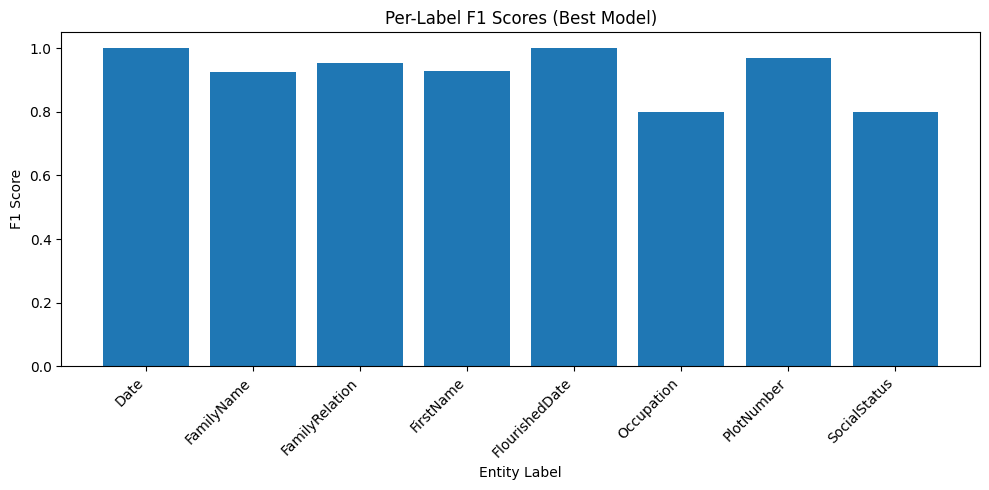

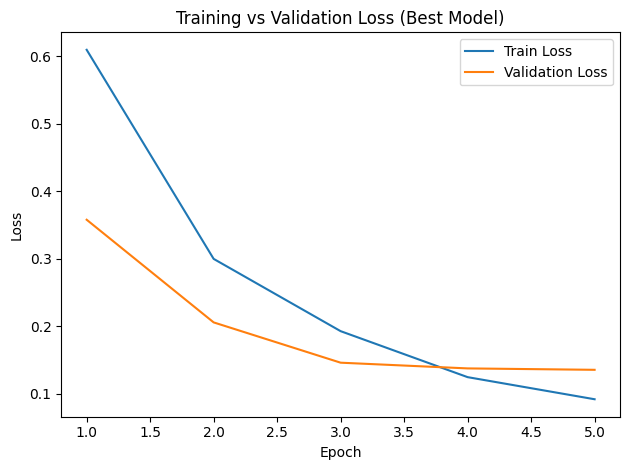

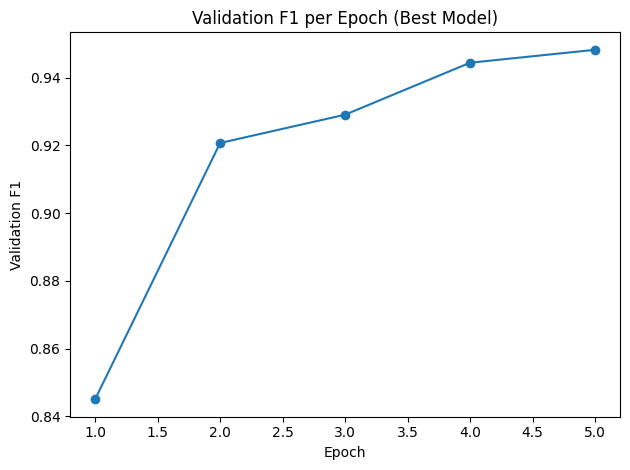

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seqeval.metrics import classification_report

# -------------------------------
# 1️⃣ Load best model
# -------------------------------
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
print("✅ Best model loaded for visualization")

# -------------------------------
# 2️⃣ Re-run evaluation ONCE
# -------------------------------
val_loss, val_f1, all_true, all_pred = evaluate()

print(f"Best Model Val Loss: {val_loss:.4f}")
print(f"Best Model Val F1:   {val_f1:.4f}")

# -------------------------------
# 3️⃣ Find best epoch (for curves)
# -------------------------------
best_epoch = int(np.argmax(val_f1s)) + 1
epochs = range(1, best_epoch + 1)


report = classification_report(
    all_true,
    all_pred,
    output_dict=True
)

df = pd.DataFrame(report).transpose()
df_report = pd.DataFrame(report).transpose()

# Optional: drop averages and NickName
df_report = df_report.drop(
    index=["micro avg", "macro avg", "weighted avg", "NickName"],
    errors="ignore"
)

# Round for readability
df_report = df_report.round(3)
print(df_report)

df = df.drop(
    index=[
        "micro avg",
        "macro avg",
        "weighted avg",
        "NickName"
    ],
    errors="ignore"
)

df = df[df["support"] > 0]

plt.figure(figsize=(10, 5))
plt.bar(df.index, df["f1-score"])
plt.xlabel("Entity Label")
plt.ylabel("F1 Score")
plt.title("Per-Label F1 Scores (Best Model)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs, train_losses[:best_epoch], label="Train Loss")
plt.plot(epochs, val_losses[:best_epoch], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Best Model)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 5️⃣ Validation F1 curve
# -------------------------------
plt.figure()
plt.plot(epochs, val_f1s[:best_epoch], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation F1")
plt.title("Validation F1 per Epoch (Best Model)")
plt.tight_layout()
plt.show()






RoBerta
